# Predicting Social Media Engagement

In [1]:
#Data wrangling and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.simplefilter("ignore")

In [2]:
#Model libraries
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,auc,roc_auc_score,precision_score,recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

In [3]:
#Feature plot libraries
from yellowbrick.model_selection import FeatureImportances
from xgboost import plot_importance

## Importing Dataset 

In [4]:
#importing data
data=pd.read_csv('dataset.csv')

In [5]:
#Overview of dataset
data.sample(5)

,Presidential_Candidate,Message,Created_Time,Type,Link,story,Likes_Count,Comments_Count,Shares_Count,Engagement
761,Nana Addo Dankwa Akufo-Addo,Video: Campaigning in Atwima Nwabiagya North c...,2016-10-22T14:03:34+0000,video,https://www.facebook.com/nakufoaddo/videos/101...,NaN,4410,171,487,5068
797,Nana Addo Dankwa Akufo-Addo,NaN,2016-10-18T09:37:54+0000,status,NaN,NaN,913,13,0,926
2113,John Dramani Mahama,NaN,2016-11-19T16:30:01+0000,photo,https://www.facebook.com/JDMahama/photos/a.477...,John Dramani Mahama added a new photo.,1442,67,95,1604
2199,John Dramani Mahama,President Mahama at the 71st #UNGA,2016-09-21T15:10:04+0000,video,https://www.facebook.com/JDMahama/videos/13396...,John Dramani Mahama was live.,3913,822,545,5280
199,Nana Addo Dankwa Akufo-Addo,A 3-day government retreat was held at Peduase...,2017-04-11T18:29:05+0000,photo,https://www.facebook.com/nakufoaddo/photos/a.1...,Nana Addo Dankwa Akufo-Addo added 13 new photo...,5888,164,515,6567


In [6]:
#Summary
data.describe()

,Likes_Count,Comments_Count,Shares_Count,Engagement
count,2941.000000,2941.000000,2941.000000,2941.000000
mean,4691.839170,384.531792,326.458007,5402.828970
std,6406.280389,651.221690,569.724163,7113.919245
min,6.000000,0.000000,0.000000,42.000000
25%,1120.000000,65.000000,67.000000,1358.000000
50%,2626.000000,155.000000,162.000000,3078.000000
75%,5394.000000,409.000000,374.000000,6429.000000
max,85438.000000,9058.000000,13132.000000,96022.000000


In [7]:
#Shape of data
data.shape

(2941, 10)

In [8]:
#Data type of variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2941 entries, 0 to 2940
Data columns (total 10 columns):
Presidential_Candidate    2941 non-null object
Message                   2394 non-null object
Created_Time              2941 non-null object
Type                      2941 non-null object
Link                      2375 non-null object
story                     1432 non-null object
Likes_Count               2941 non-null int64
Comments_Count            2941 non-null int64
Shares_Count              2941 non-null int64
Engagement                2941 non-null int64
dtypes: int64(4), object(6)
memory usage: 229.9+ KB


## Data Preprocessing 

In [9]:
#Dropping Likes_Count, Comments_Count,Shares_Count
data=data.drop(['Likes_Count','Comments_Count','Shares_Count','Message','story','Link'], axis=1)

In [10]:
data.head()

,Presidential_Candidate,Created_Time,Type,Engagement
0,Nana Addo Dankwa Akufo-Addo,2017-06-30T20:20:00+0000,link,2581
1,Nana Addo Dankwa Akufo-Addo,2017-06-30T18:04:02+0000,photo,5627
2,Nana Addo Dankwa Akufo-Addo,2017-06-30T07:55:38+0000,status,5729
3,Nana Addo Dankwa Akufo-Addo,2017-06-29T14:45:54+0000,photo,4936
4,Nana Addo Dankwa Akufo-Addo,2017-06-29T12:15:15+0000,link,4802


In [11]:
#Creating Engagement_Level Column
#This is based on 50% Quartile on Engagement
def age_groups(series):
    if series <= 3078:
        return 0
    elif series > 3078:
        return 1

data['Engagement_Level'] = data['Engagement'].apply(age_groups)

In [12]:
data.head()

,Presidential_Candidate,Created_Time,Type,Engagement,Engagement_Level
0,Nana Addo Dankwa Akufo-Addo,2017-06-30T20:20:00+0000,link,2581,0
1,Nana Addo Dankwa Akufo-Addo,2017-06-30T18:04:02+0000,photo,5627,1
2,Nana Addo Dankwa Akufo-Addo,2017-06-30T07:55:38+0000,status,5729,1
3,Nana Addo Dankwa Akufo-Addo,2017-06-29T14:45:54+0000,photo,4936,1
4,Nana Addo Dankwa Akufo-Addo,2017-06-29T12:15:15+0000,link,4802,1


In [13]:
data['Created_Time']= pd.to_datetime(data['Created_Time'])
data['year'] = data['Created_Time'].dt.year
data['month'] = data['Created_Time'].dt.month
data['day'] = data['Created_Time'].dt.day
data['hour'] = data['Created_Time'].dt.hour
data['minute'] = data['Created_Time'].dt.minute
data['weekday'] = data['Created_Time'].dt.weekday
data['day_name'] = data['Created_Time'].dt.weekday_name
data['dayofyear'] = data['Created_Time'].dt.dayofyear
data['quarter'] = data['Created_Time'].dt.quarter
data['month_name'] = data['Created_Time'].dt.month_name(locale = 'English')

In [14]:
#Creating Engagement_Level Column
#This is based on 50% Quartile on Engagement
def age(series):
    if series <= 11:
        return "AM"
    elif series > 11:
        return "PM"

data['time_period'] = data['hour'].apply(age)

In [15]:
#Creating Engagement_Level Column
#This is based on 50% Quartile on Engagement
def ages(series):
    if series <= 2016:
        a= 2016 - series
        return a
    elif series > 2016:
        a= 2020 - series
        return a

data['year_vote'] = data['year'].apply(ages)

In [16]:
data.groupby(["year_vote"]).sum()

,Engagement,Engagement_Level,year,month,day,hour,minute,weekday,dayofyear,quarter
year_vote,,,,,,,,,,
0,9021318,817,2322432,9933,18613,15219,27017,3279,286025,3689
1,1624511,164,884585,3165,6594,6016,11881,1235,89166,1191
2,1100881,86,1025126,3179,7977,7160,15004,1277,88744,1239
3,4143010,403,1695057,3817,12720,11364,23432,2300,102489,1567


In [17]:
data.head(20)

,Presidential_Candidate,Created_Time,Type,Engagement,Engagement_Level,year,month,day,hour,minute,weekday,day_name,dayofyear,quarter,month_name,time_period,year_vote
0,Nana Addo Dankwa Akufo-Addo,2017-06-30 20:20:00+00:00,link,2581,0,2017,6,30,20,20,4,Friday,181,2,June,PM,3
1,Nana Addo Dankwa Akufo-Addo,2017-06-30 18:04:02+00:00,photo,5627,1,2017,6,30,18,4,4,Friday,181,2,June,PM,3
2,Nana Addo Dankwa Akufo-Addo,2017-06-30 07:55:38+00:00,status,5729,1,2017,6,30,7,55,4,Friday,181,2,June,AM,3
3,Nana Addo Dankwa Akufo-Addo,2017-06-29 14:45:54+00:00,photo,4936,1,2017,6,29,14,45,3,Thursday,180,2,June,PM,3
4,Nana Addo Dankwa Akufo-Addo,2017-06-29 12:15:15+00:00,link,4802,1,2017,6,29,12,15,3,Thursday,180,2,June,PM,3
5,Nana Addo Dankwa Akufo-Addo,2017-06-29 09:00:00+00:00,video,1198,0,2017,6,29,9,0,3,Thursday,180,2,June,AM,3
6,Nana Addo Dankwa Akufo-Addo,2017-06-28 17:06:40+00:00,link,3327,1,2017,6,28,17,6,2,Wednesday,179,2,June,PM,3
7,Nana Addo Dankwa Akufo-Addo,2017-06-28 16:41:05+00:00,video,2923,0,2017,6,28,16,41,2,Wednesday,179,2,June,PM,3
8,Nana Addo Dankwa Akufo-Addo,2017-06-28 09:16:36+00:00,link,3291,1,2017,6,28,9,16,2,Wednesday,179,2,June,AM,3
9,Nana Addo Dankwa Akufo-Addo,2017-06-27 20:58:14+00:00,photo,6902,1,2017,6,27,20,58,1,Tuesday,178,2,June,PM,3


In [18]:
data.head()

,Presidential_Candidate,Created_Time,Type,Engagement,Engagement_Level,year,month,day,hour,minute,weekday,day_name,dayofyear,quarter,month_name,time_period,year_vote
0,Nana Addo Dankwa Akufo-Addo,2017-06-30 20:20:00+00:00,link,2581,0,2017,6,30,20,20,4,Friday,181,2,June,PM,3
1,Nana Addo Dankwa Akufo-Addo,2017-06-30 18:04:02+00:00,photo,5627,1,2017,6,30,18,4,4,Friday,181,2,June,PM,3
2,Nana Addo Dankwa Akufo-Addo,2017-06-30 07:55:38+00:00,status,5729,1,2017,6,30,7,55,4,Friday,181,2,June,AM,3
3,Nana Addo Dankwa Akufo-Addo,2017-06-29 14:45:54+00:00,photo,4936,1,2017,6,29,14,45,3,Thursday,180,2,June,PM,3
4,Nana Addo Dankwa Akufo-Addo,2017-06-29 12:15:15+00:00,link,4802,1,2017,6,29,12,15,3,Thursday,180,2,June,PM,3


# Exploratory Data Analysis 

### EPA for 2016 year 

In [19]:
##Subsetting year 2016
data_16=data[data.year == 2016]

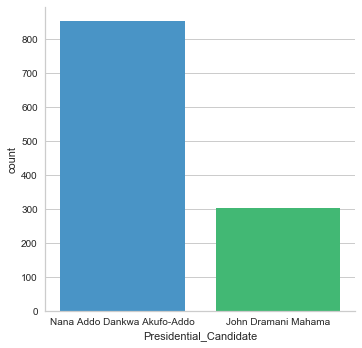

In [20]:
#Barplot of Presidential_Candidate
sns.catplot(x='Presidential_Candidate',kind='count',data=data_16,palette=("#3498db","#2ecc71"))

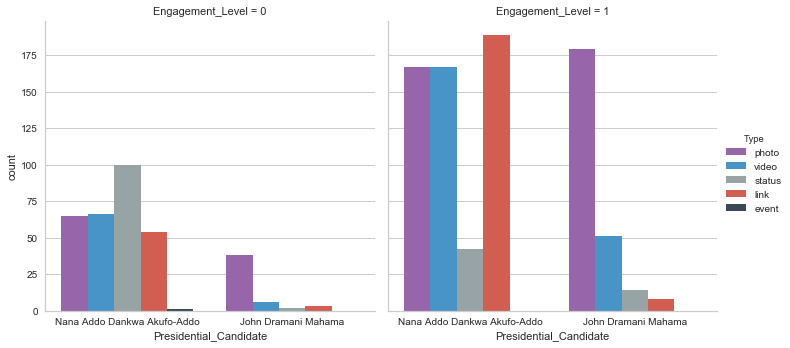

In [21]:
#Stackplot of Presidential_Candidate,Engagement_Level,Type
sns.catplot(x='Presidential_Candidate',kind='count',col='Engagement_Level',hue='Type',data=data_16,palette=("#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"))

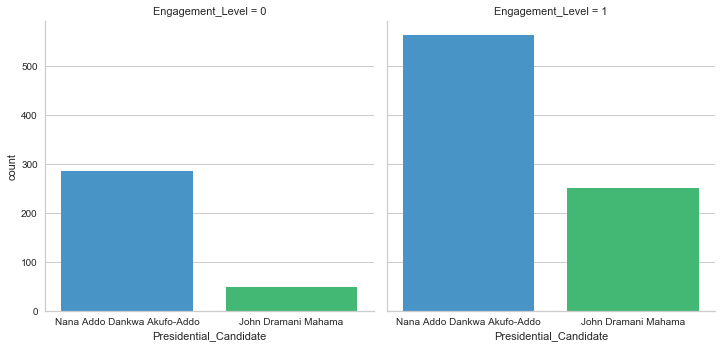

In [22]:
#Stackplot of Presidential_Candidate,Engagement_Level
sns.catplot(x='Presidential_Candidate',kind='count',col='Engagement_Level',data=data_16,palette=("#3498db","#2ecc71"))

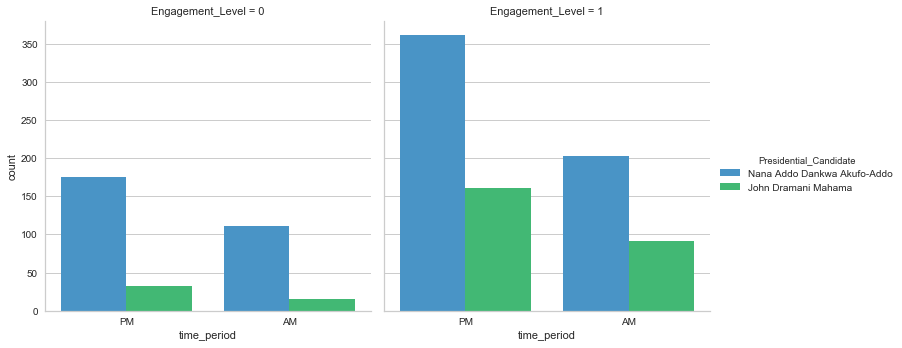

In [23]:
#Stackplot of time_period,Engagement_Level, Presidential_Candidate
sns.catplot(x='time_period',kind='count',col='Engagement_Level',hue='Presidential_Candidate',data=data_16,palette=("#3498db","#2ecc71"))

<Figure size 1440x720 with 0 Axes>

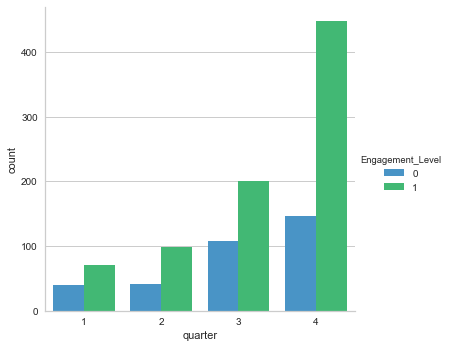

In [67]:
#Stackplot of time_period,Engagement_Level, Presidential_Candidate
plt.figure(figsize=(20,10))
sns.catplot(x='quarter',kind='count',hue='Engagement_Level',data=data_16,palette=("#3498db","#2ecc71"))

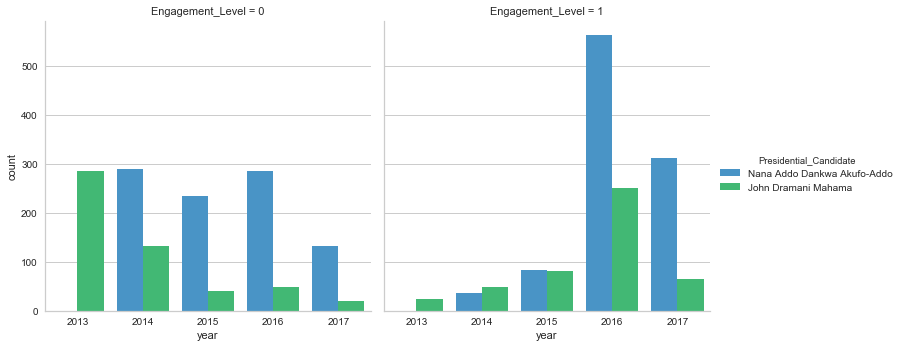

In [24]:
#Stackplot of time_period,Engagement_Level, Presidential_Candidate
sns.catplot(x='year',kind='count',col='Engagement_Level',hue='Presidential_Candidate',data=data,palette=("#3498db","#2ecc71"))

<Figure size 1080x720 with 0 Axes>

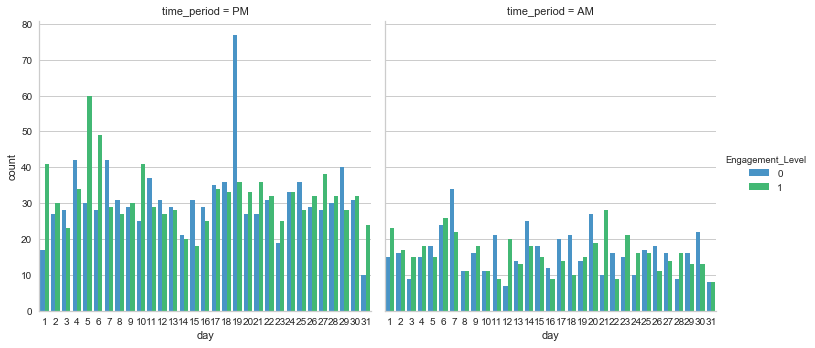

In [25]:
#Stackplot of time_period,Engagement_Level, Presidential_Candidate
plt.figure(figsize=(15,10))
sns.catplot(x='day',kind='count',col='time_period',hue='Engagement_Level',data=data,palette=("#3498db","#2ecc71"))

<Figure size 1080x720 with 0 Axes>

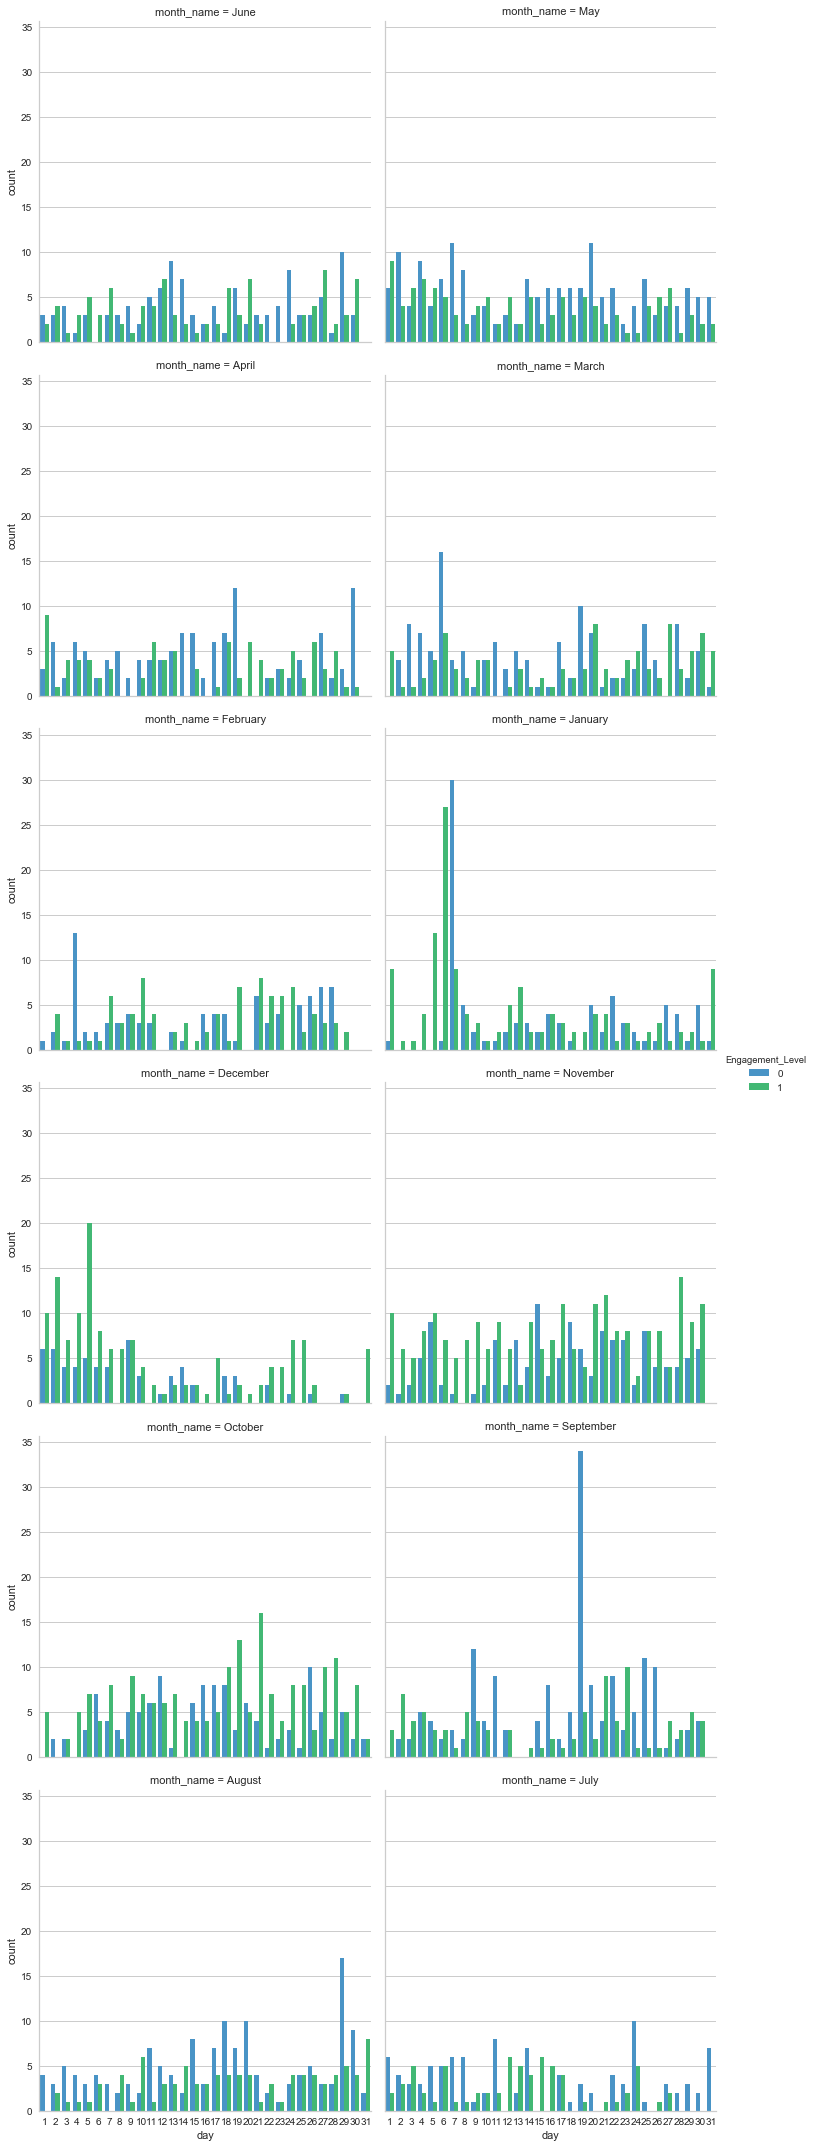

In [26]:
#Stackplot of time_period,Engagement_Level, Presidential_Candidate
plt.figure(figsize=(15,10))
sns.catplot(x='day',kind='count',col='month_name',col_wrap=2,hue='Engagement_Level',data=data,palette=("#3498db","#2ecc71"))

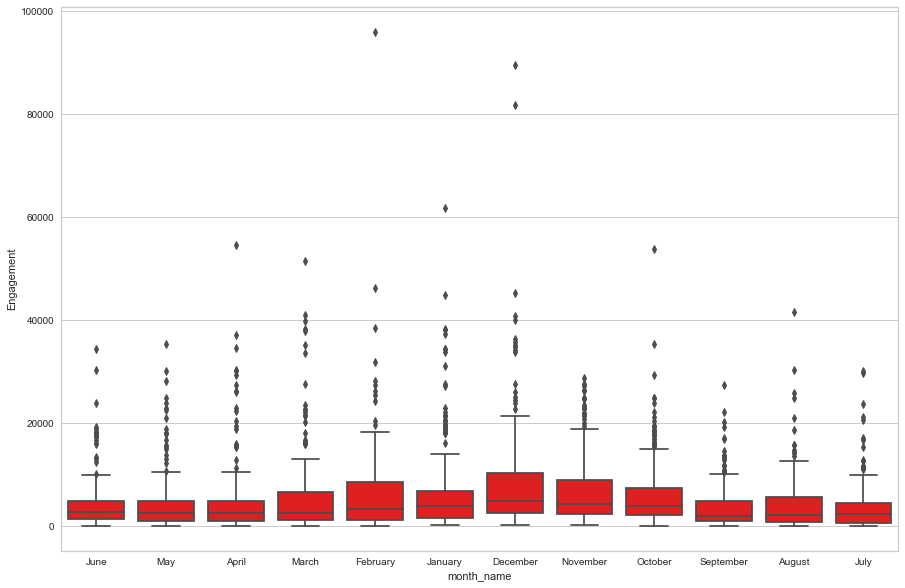

In [27]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data,x='month_name',y='Engagement',color='red')

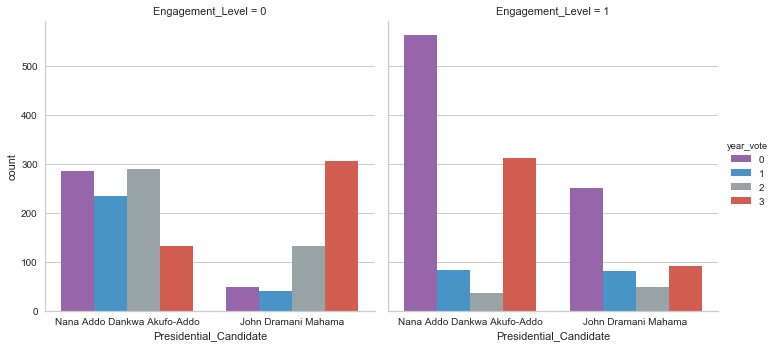

In [28]:
#Stackplot of Presidential_Candidate, Engagement_Level, year_vote
sns.catplot(x='Presidential_Candidate',kind='count',col='Engagement_Level',hue='year_vote',data=data,palette=("#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"))

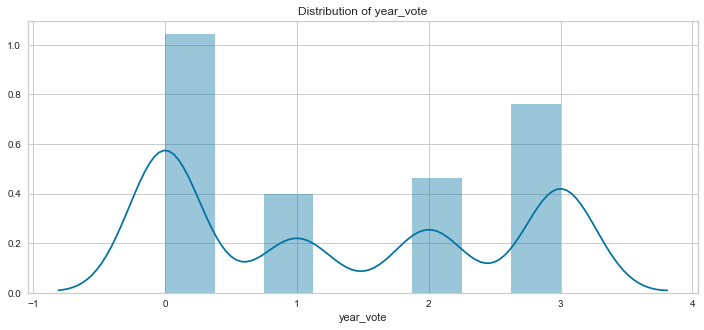

In [29]:
#Kernel density plot on Age
plt.figure(figsize=(12,5))
plt.title("Distribution of year_vote")
sns.distplot(data['year_vote'],color='B')

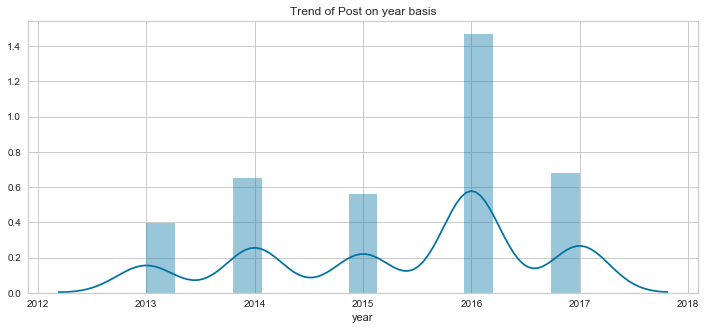

In [30]:
#Kernel density plot on Age
plt.figure(figsize=(12,5))
plt.title("Trend of Post on year basis")
sns.distplot(data['year'],color='B')

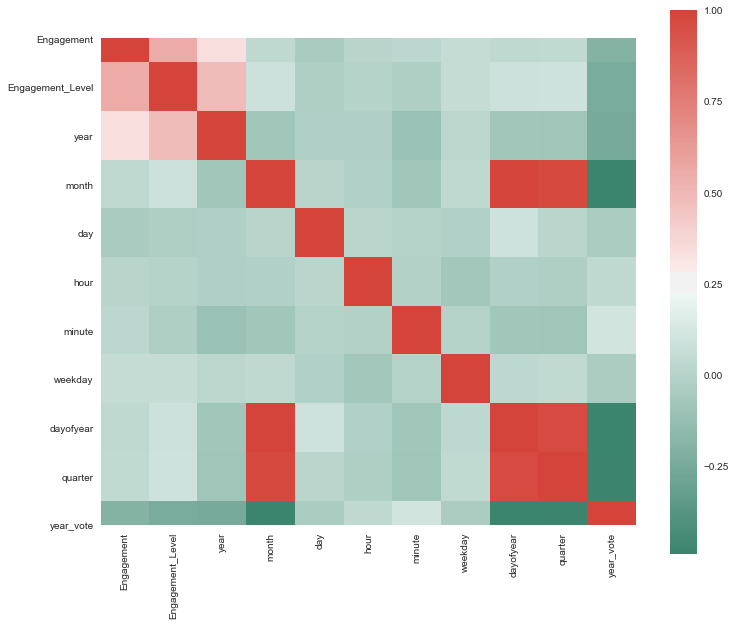

In [31]:
#Correlation Plot
f,ax=plt.subplots(figsize=(12,10))
corr=data.corr()
sns.heatmap(data.corr(),mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(520,14,as_cmap=True),square=True, ax=ax)

## Data Preprocessing 

In [32]:
#Dropping Likes_Count, Comments_Count,Shares_Count
data=data.drop(['Created_Time','Engagement'], axis=1)

In [33]:
#Checking the percentage of missing numbers 
Train_missing=data.isna().mean().round(4) * 100
Train_missing

Presidential_Candidate    0.0
Type                      0.0
Engagement_Level          0.0
year                      0.0
month                     0.0
day                       0.0
hour                      0.0
minute                    0.0
weekday                   0.0
day_name                  0.0
dayofyear                 0.0
quarter                   0.0
month_name                0.0
time_period               0.0
year_vote                 0.0
dtype: float64

In [34]:
#Dummy Variables on Categorical Variables
data_dummies=pd.get_dummies(data, prefix='', prefix_sep='', columns=['Presidential_Candidate','Type','day_name','month_name','time_period'])

In [35]:
data_dummies

,Engagement_Level,year,month,day,hour,minute,weekday,dayofyear,quarter,year_vote,...,January,July,June,March,May,November,October,September,AM,PM
0,0,2017,6,30,20,20,4,181,2,3,...,0,0,1,0,0,0,0,0,0,1
1,1,2017,6,30,18,4,4,181,2,3,...,0,0,1,0,0,0,0,0,0,1
2,1,2017,6,30,7,55,4,181,2,3,...,0,0,1,0,0,0,0,0,1,0
3,1,2017,6,29,14,45,3,180,2,3,...,0,0,1,0,0,0,0,0,0,1
4,1,2017,6,29,12,15,3,180,2,3,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,0,2013,1,30,16,53,2,30,1,3,...,1,0,0,0,0,0,0,0,0,1
2937,0,2013,1,30,16,48,2,30,1,3,...,1,0,0,0,0,0,0,0,0,1
2938,0,2013,1,28,19,1,0,28,1,3,...,1,0,0,0,0,0,0,0,0,1
2939,0,2013,1,28,13,53,0,28,1,3,...,1,0,0,0,0,0,0,0,0,1


## Splitting joined dataset into Train and Test set 

In [36]:
# Separate input features (X) and target variable (y)
y = data_dummies.Engagement_Level
X = data_dummies.drop('Engagement_Level', axis=1)
y.shape,  X.shape

((2941,), (2941, 37))

In [63]:
#Splitting dataset into Train and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [38]:
#Percentage of imbalance data in target feature
print('0 (Engagement_Level)', round(y_train.value_counts()[0]/len(y_train) * 100,2), '% of the dataset')
print('1 (Engagement_Level)', round(y_train.value_counts()[1]/len(y_train) * 100,2), '% of the dataset')

0 (Engagement_Level) 50.0 % of the dataset
1 (Engagement_Level) 50.0 % of the dataset


In [39]:
#Standardization
ss = StandardScaler()
X_train_scale = pd.DataFrame(ss.fit_transform(X_train),columns = X_train.columns)
X_test_scale = pd.DataFrame(ss.fit_transform(X_test),columns = X_test.columns)
X_train_scale
X_test_scale

,year,month,day,hour,minute,weekday,dayofyear,quarter,year_vote,John Dramani Mahama,...,January,July,June,March,May,November,October,September,AM,PM
0,-0.998867,0.360548,0.308240,-0.132628,-1.219239,-0.909691,0.378566,0.369804,0.497451,-0.789043,...,-0.291058,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,-0.311182,-0.692748,0.692748
1,-0.212326,-1.365978,-1.735514,0.289630,0.565409,1.756021,-1.490205,-1.379709,-0.307490,-0.789043,...,-0.291058,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,-0.311182,-0.692748,0.692748
2,-1.785408,-0.502715,-0.940721,-1.821658,0.457249,-0.376549,-0.588687,-0.504953,1.302391,1.267357,...,-0.291058,-0.227565,-0.307889,-0.284137,3.180127,-0.355239,-0.355239,-0.311182,1.443527,-1.443527
3,1.360756,-1.078224,-0.373011,-0.977143,1.214372,-1.442834,-1.114572,-1.379709,1.302391,1.267357,...,-0.291058,-0.227565,-0.307889,3.519427,-0.314453,-0.355239,-0.355239,-0.311182,1.443527,-1.443527
4,0.574215,0.360548,0.194698,0.500759,-0.732516,0.156594,0.378566,0.369804,-1.112431,-0.789043,...,-0.291058,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,-0.311182,-0.692748,0.692748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,-0.998867,-1.653732,0.535324,-0.132628,0.078687,-0.909691,-1.593503,-1.379709,0.497451,1.267357,...,3.435746,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,-0.311182,-0.692748,0.692748
585,-0.998867,0.360548,1.557201,1.134145,-1.111078,1.222878,0.481865,0.369804,0.497451,1.267357,...,-0.291058,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,-0.311182,-0.692748,0.692748
586,-0.212326,-0.790469,0.308240,-0.343756,0.565409,1.756021,-0.767112,-0.504953,-0.307490,-0.789043,...,-0.291058,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,-0.311182,-0.692748,0.692748
587,0.574215,0.648302,0.308240,0.711888,-0.299874,-1.442834,0.679072,0.369804,-1.112431,-0.789043,...,-0.291058,-0.227565,-0.307889,-0.284137,-0.314453,-0.355239,-0.355239,3.213553,-0.692748,0.692748


## Removing Contast Features 

In [40]:
constant_filter = VarianceThreshold(threshold=0.0)
constant_filter.fit(X_train)

VarianceThreshold(threshold=0.0)

In [41]:
constant_filter.get_support().sum()

37

In [42]:
constant_list = [not temp for temp in constant_filter.get_support()]
constant_list

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [43]:
X.columns[constant_list]

Index([], dtype='object')

In [44]:
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)

In [45]:
X_train_filter.shape, X_test_filter.shape, X_train.shape

((2352, 37), (589, 37), (2352, 37))

## Removal of Quasi constant features 

In [46]:
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(X_train_filter)

VarianceThreshold(threshold=0.01)

In [47]:
quasi_constant_filter.get_support().sum()

36

In [48]:
X_train_quasi_filter = quasi_constant_filter.transform(X_train_filter)
X_test_quasi_filter = quasi_constant_filter.transform(X_test_filter)

In [49]:
X_train_quasi_filter.shape, X_test_quasi_filter.shape

((2352, 36), (589, 36))

## Removing Duplicated Features 

In [50]:
X_train_T = X_train_quasi_filter.T
X_test_T = X_test_quasi_filter.T

In [51]:
type(X_train_T)

numpy.ndarray

In [52]:
X_train_T = pd.DataFrame(X_train.T)
X_test_T = pd.DataFrame(X_test.T)

In [53]:
X_train_T.shape, X_test_T.shape

((37, 2352), (37, 589))

In [54]:
X_train_T.duplicated().sum()

0

In [55]:
duplicated_features = X_train_T.duplicated()
duplicated_features

year                           False
month                          False
day                            False
hour                           False
minute                         False
weekday                        False
dayofyear                      False
quarter                        False
year_vote                      False
John Dramani Mahama            False
Nana Addo Dankwa Akufo-Addo    False
event                          False
link                           False
photo                          False
status                         False
video                          False
Friday                         False
Monday                         False
Saturday                       False
Sunday                         False
Thursday                       False
Tuesday                        False
Wednesday                      False
April                          False
August                         False
December                       False
February                       False
J

In [56]:
features_to_keep = [not index for index in duplicated_features]

In [57]:
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T

In [58]:
X_train_unique.shape, X_test_unique.shape

((2352, 37), (589, 37))

In [69]:
scaler = StandardScaler().fit(X_train_unique)
X_train_unique = scaler.transform(X_train_unique)
X_test_unique = scaler.transform(X_test_unique)

In [70]:
X_train_unique = pd.DataFrame(X_train_unique)
X_test_unique = pd.DataFrame(X_test_unique)

In [71]:
X_train_unique.shape, X_test_unique.shape

((2352, 37), (589, 37))

## Applying Classification Models 

## Decision Tree Classifier 

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       295
           1       0.76      0.66      0.71       294

    accuracy                           0.72       589
   macro avg       0.73      0.72      0.72       589
weighted avg       0.73      0.72      0.72       589

0.7249575551782682
[[233  62]
 [100 194]]
precision =  0.7578125 
 recall =  0.6598639455782312


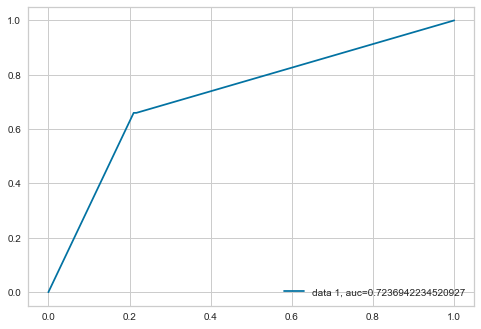

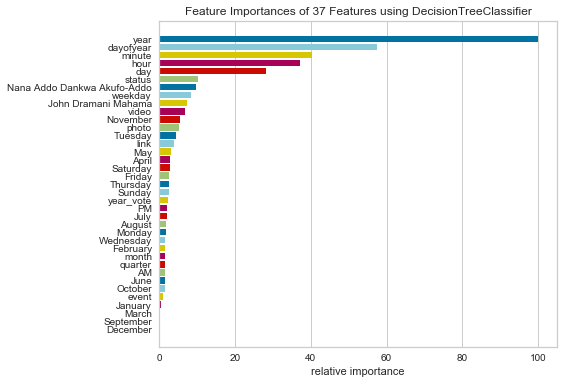

Wall time: 971 ms


In [59]:
%%time

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

pred = dtree.predict(X_test)
print(classification_report(y_test,pred))
print (accuracy_score(y_test,pred))
print (confusion_matrix(y_test,pred))

precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

y_pred_proba = dtree.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#impFeatures = pd.DataFrame(dtree.feature_importances_ ,index=X_train.columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
#print (impFeatures)

#Feature Selection for Decision Tree
dec_tre = DecisionTreeClassifier()
viz = FeatureImportances(dec_tre)
viz.fit(X_train,y_train)
viz.show()

## Random Forest Classifier 

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       295
           1       0.79      0.75      0.77       294

    accuracy                           0.78       589
   macro avg       0.78      0.78      0.78       589
weighted avg       0.78      0.78      0.78       589

0.7775891341256367
[[238  57]
 [ 74 220]]
precision =  0.7942238267148014 
 recall =  0.7482993197278912


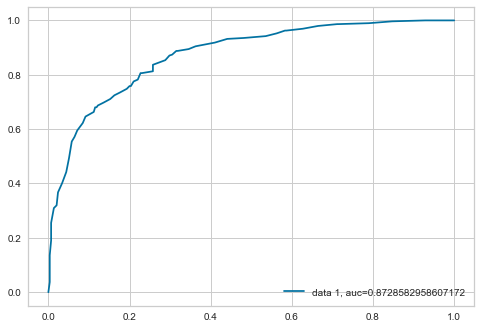

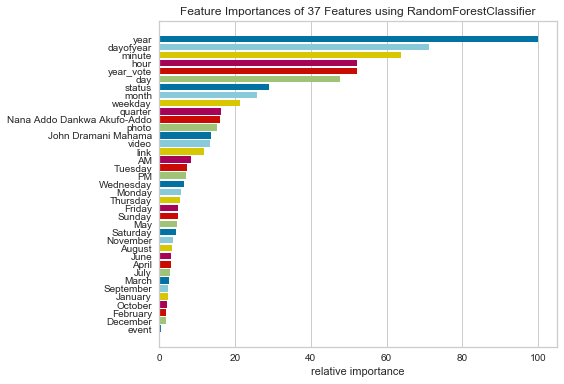

Wall time: 1.56 s


In [60]:
%%time
ran = RandomForestClassifier(n_estimators=50,random_state=0)
ran.fit(X_train,y_train)

pred = ran.predict(X_test)
print(classification_report(y_test,pred))
print (accuracy_score(y_test,pred))
print (confusion_matrix(y_test,pred))

precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

y_pred_proba = ran.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#Feature Selection for Random Forest
ran_for=RandomForestClassifier()
viz = FeatureImportances(ran_for)
viz.fit(X_train,y_train)
viz.show()

## Logistic Regression Classifier 

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       295
           1       0.68      0.68      0.68       294

    accuracy                           0.68       589
   macro avg       0.68      0.68      0.68       589
weighted avg       0.68      0.68      0.68       589

0.6791171477079796
[[200  95]
 [ 94 200]]
precision =  0.6779661016949152 
 recall =  0.6802721088435374


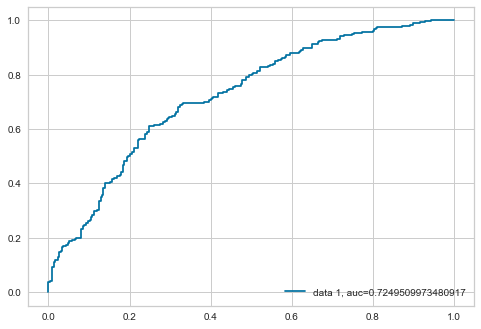

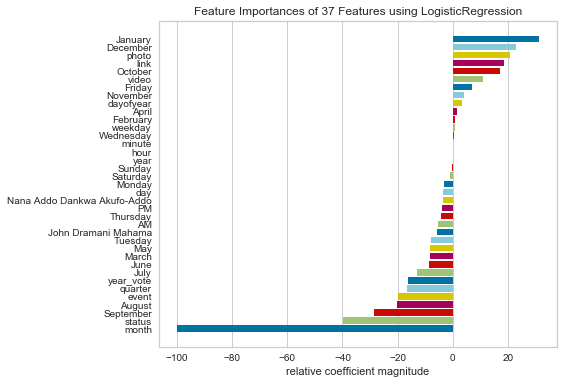

Wall time: 1.21 s


In [61]:
%%time
log = LogisticRegression(penalty='l2', C=0.1)
log.fit(X_train,y_train)

pred = log.predict(X_test)
print(classification_report(y_test,pred))
print (accuracy_score(y_test,pred))
print (confusion_matrix(y_test,pred))

precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

y_pred_proba = log.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
#impFeatures = pd.DataFrame(log.coef_[0] ,index=X_train.columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
#print (impFeatures)

log_reg = LogisticRegression(multi_class="auto", solver="liblinear")
viz = FeatureImportances(log_reg)
viz.fit(X_train,y_train)
viz.show()

## XGBoost Classifier 

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       295
           1       0.79      0.80      0.79       294

    accuracy                           0.79       589
   macro avg       0.79      0.79      0.79       589
weighted avg       0.79      0.79      0.79       589

0.7894736842105263
[[231  64]
 [ 60 234]]
precision =  0.785234899328859 
 recall =  0.7959183673469388


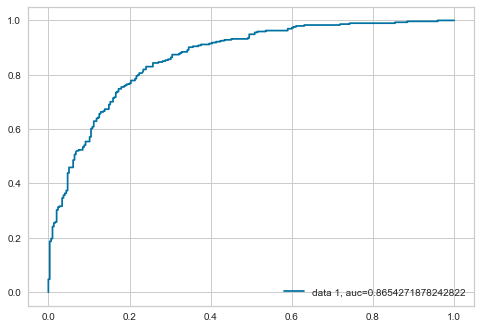

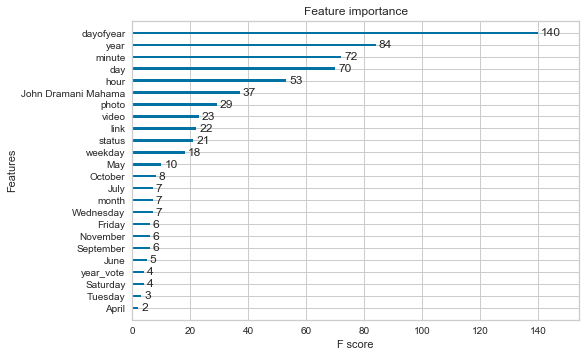

Wall time: 1.41 s


In [64]:
%%time
xgb=XGBClassifier()
xgb=xgb.fit(X_train,y_train)

pred = xgb.predict(X_test)
print(classification_report(y_test,pred))
print (accuracy_score(y_test,pred))
print (confusion_matrix(y_test,pred))

precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# plot feature importance
plot_importance(xgb)
plt.show()